In [1]:
#%reset -f -s
%matplotlib inline
'''------------------------------------------------------------------
MA-eR-PINN: eRange Prediction using Physics-Informed Neural Networks
---------------------------------------------------------------------
Version: V2.0      Modified: 12.01.2025        William Siegle
---------------------------------------------------------------------
PTRAIN - Standard Pipeline Framework for Training the PINN
+ OPTUNA - Hyperparameter Optimization using Optuna
------------------------------------------------------------------''';

In [2]:
# MA-eR-PINN: CONFIGURATION FILE -------------------------------------------------
from pathlib import Path
CONFIG = {
    # SYSTEM: ---------------------------------------------------------------------
    "GPU_SELECT":       0,
    "ROOT":             Path('../..').resolve(),
    "INPUT_LOCATION":   Path("TripSequences", "trips_processed_pinn_2"), 
    "OUTPUT_LOCATION":  Path("src", "models", "pth"),
    "SEED"  :           20,
    "MIXED_PRECISION":  True,

    # DATA PREPROCESSING: ---------------------------------------------------------
    "TRAIN_VAL_TEST":   [0.8, 0.1, 0.1], # [train, val, test splits]
    "MAX_FILES":        None, # None: all files
    "MIN_SEQ_LENGTH":   3600, # minimum sequence length in s to be included in DataSets
    "SCALERS":          {'feature_scaler': 'MinMaxScaler()','target_scaler': 'MinMaxScaler()','prior_scaler': 'MinMaxScaler()'},

    # FEATURES: -------------------------------------------------------------------
    "FEATURES":         ['accelpdlposn_cval','actdrvtrnpwrprc_cval','actualdcvoltage_pti1','actualspeed_pti1','actualtorque_pti1',
                        'airtempinsd_cval_hvac','airtempinsd_rq','airtempoutsd_cval_cpc','altitude_cval_ippc','brc_stat_brc1','brktempra_cval',
                        'bs_brk_cval','currpwr_contendrnbrkresist_cval','elcomp_pwrcons_cval','epto_pwr_cval','hv_bat_dc_momvolt_cval_bms1',
                        'hv_batavcelltemp_cval_bms1','hv_batcurr_cval_bms1','hv_batisores_cval_e2e','hv_batmaxchrgpwrlim_cval_1',
                        'hv_batmaxdischrgpwrlim_cval_1','hv_curr_cval_dcl1','hv_dclink_volt_cval_dcl1','hv_ptc_cabin1_pwr_cval','hv_pwr_cval_dcl1',
                        'lv_convpwr_cval_dcl1','maxrecuppwrprc_cval','maxtracpwrpct_cval','motortemperature_pti1','powerstagetemperature_pti1',
                        'rmsmotorcurrent_pti1','roadgrad_cval_pt','selgr_rq_pt','start_soc','txoiltemp_cval_tcm','vehspd_cval_cpc','vehweight_cval_pt'],                 
    "TARGETS":          ['hv_bat_soc_cval_bms1'],
    "PRIORS":           ['emot_soc_pred'],  

    # MODEL: -----------------------------------------------------------------------
    "HIDDEN_SIZE":      12,    # features in the hidden state h
    "NUM_LAYERS":       3,      # recurrent layers for stacked LSTMs. Default: 1
    "DROPOUT":          0.35,   # usually: [0.2 - 0.5]
    
    # TRAINING & OPTIMIZER: --------------------------------------------------------
    "NUM_EPOCHS":       3,
    "BATCH_SIZE":       32,         # [2, 4, 8, 16, 32, 64, 128, 256]
    "LEARNING_RATE":    1e-3,       # 0.001 lr
    "WEIGHT_DECAY":     1e-3,       # weight decay coefficient (default: 1e-2)
    "MOMENTUM_SGD":     0.1,        # (default: 0.0)
    "OPTIMIZER":        'adamw',    # ('adam', 'sgd', 'adamw')
    "WEIGHT_INIT_TYPE": 'he',  # ('he', 'normal', 'default')
    "CLIP_GRAD":        2.0,        # default: None
    "LRSCHEDULER":      "torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)",  # constant LR for 1.0 as multiplicative factor
                        # torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 3, factor = 0.5, min_lr = 1e-7)

    # LOSS FUNCTION: ---------------------------------------------------------------
    "CRITERION":        "nn.SmoothL1Loss()", # ['nn.MSELoss()', 'nn.L1Loss()', 'nn.SmoothL1Loss()', 'nn.HuberLoss()', 'MASE()']
    #"P_LOSS_FACTOR":    0.5, # Physics loss factor
}

___
SETUP: Locate devices & system folders

In [3]:
# LOCATE REPOSITORY/DATASTORAGE IN CURRENT SYSTEM ENVIRONMENT  ---------------------------
import sys, os
for key in CONFIG: globals()[key] = CONFIG[key]
print(ROOT)
if 'ROOT' not in globals(): ROOT = Path('../..').resolve()
sys.path.append(os.path.abspath(ROOT))

# INTERNAL MODULE IMPORTS ----------------------------------------------------------------
from src.__init__ import *
from src.utils.data_utils import *
from src.utils.preprocess_utils import *
from src.utils.eval_utils import *
from src.utils.Trainers import *
from src.models.lstm_models import *

# SETUP ENVIRONMENT ---------------------------------------------------------------------
DATA_PATH, IS_NOTEBOOK, DEVICE, LOG_FILE_NAME, TS = setup_environment(CONFIG, ROOT, SEED, GPU_SELECT)
if not IS_NOTEBOOK: output_file = open(f"{LOG_FILE_NAME}", "w"); sys.stdout = Tee(sys.stdout, output_file); sys.stderr = Tee(sys.stderr, output_file)

# FILE SOURCES ---------------------------------------------------------------
input_folder = Path(DATA_PATH, INPUT_LOCATION) # Trip parquet files
pth_folder = Path(ROOT, OUTPUT_LOCATION, f"{TS}")
pth_folder.mkdir(parents=True, exist_ok=True)
files, trip_lengths, indices_by_length, sorted_trip_lengths, all_signals = prepare_data(input_folder, pth_folder, MAX_FILES, MIN_SEQ_LENGTH, ROOT)

/home/sieglew/MA-eR-PINN
------------------------------------------------------------
Directories:
  /home/sieglew/MA-eR-PINN:			test, .git, archive, project, data, src
  /mnt/nvme/datasets/sieglew:			TripSequences
------------------------------------------------------------
Running in notebook mode
CONFIG Dictionary:
---------------------------------------------------------------------------------------------------------------------------------
     Parameter         Value
--  ----------------  ---------------------------------------------------------------------------------------------------------
0   GPU_SELECT        0
1   ROOT              /home/sieglew/MA-eR-PINN
2   INPUT_LOCATION    TripSequences/trips_processed_pinn_2
3   OUTPUT_LOCATION   src/models/pth
4   SEED              20
5   MIXED_PRECISION   True
6   TRAIN_VAL_TEST    [0.8, 0.1, 0.1]
7   MAX_FILES         None
8   MIN_SEQ_LENGTH    3600
9   SCALERS           {'feature_scaler': 'MinMaxScaler()', 'target_scaler': 'MinMa

___
DATA SELECTION & PREPROCESSING

In [4]:
# INPUT & TARGET SPECIFICATION ---------------------------------------------------
# these signals are required for the physical Model calculation:
base_signals = ["signal_time", "hirestotalvehdist_cval_icuc", "vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", 
                "hv_batpwr_cval_bms1", "emot_pwr_cval","bs_roadincln_cval", "roadgrad_cval_pt"]

# these signals have to be dropped (from Features) in order for appropriate training:
columns_to_drop = ["signal_time",                       # works as index
                    "hirestotalvehdist_cval_icuc",      # starts from 0, obtained by speed integration
                    "latitude_cval_ippc",               # only GPS 
                    "longitude_cval_ippc",              # only GPS
                    "hv_batpwr_cval_bms1",              # directly related to target (soc_gradient)
                    "hv_batmomavldischrgen_cval_1",     # indirect target 1 in kWh
                    "hv_bat_soc_cval_bms1",              # indirect target 2 in %SoC
                    "soc_gradient",                     # actual target signal   
                    "emot_pwr_cval",                    # replaced as physical prior for PINN
                    "emot_pwr_pred",                    # actual physical prior for PINN
                    ]

# Ensure no element of "columns_to_drop" is included in "FEATURES"
assert not any(col in FEATURES for col in columns_to_drop), "Some columns to drop are still in FEATURES"

# ---------------------------------------------------
selection_1 = ["vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", 'roadgrad_cval_pt', "vehweight_cval_pt", "accelpdlposn_cval", "bs_brk_cval", "elcomp_pwrcons_cval",
               "epto_pwr_cval", "motortemperature_pti1", "powerstagetemperature_pti1", 'airtempinsd_cval_hvac', 'brktempra_cval', 'selgr_rq_pt']
selection_2 = ["hirestotalvehdist_cval_icuc", "vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", "hv_batpwr_cval_bms1", "emot_pwr_cval", "roadgrad_cval_pt"]
selection_3 = ["vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", "vehweight_cval_pt"]

In [5]:
# FEATURE SELECTION & SCALING ----------------------------------------------------------------------------
INPUT_COLUMNS = FEATURES; TARGET_COLUMN = TARGETS; PRIOR_COLUMN = PRIORS
print(f"{'-'*60}\nInput Signals:\t{len(FEATURES)}\nTarget Signals:\t{len(TARGETS)}\nPhysical Prior Signals:\t{len(PRIORS)}\n{'-'*60}")
scaler, target_scaler, prior_scaler = eval(SCALERS['feature_scaler']), eval(SCALERS['target_scaler']), eval(SCALERS['prior_scaler'])

# DATA SET SPLITTING AND SORTING ----------------------------------------------------------------
train_subset, val_subset, test_subset = random_split(files, TRAIN_VAL_TEST)

# DATALOADER SETTINGS ------------------------------------------------------------------
dataloader_settings = {'batch_size': 1, 'shuffle': True, 'collate_fn': collate_fn_PINN, 'num_workers': 8,
 'prefetch_factor': 4, 'persistent_workers': True, 'pin_memory': False if DEVICE.type == 'cpu' else True}

# PREPARE TRAIN, VAL & TEST DATALOADERS  ------------------------------------------------------------
train_subset, train_dataset, train_dataset_batches, train_loader = prepare_dataloader_PINN(train_subset, indices_by_length, \
    BATCH_SIZE, INPUT_COLUMNS, TARGET_COLUMN, PRIOR_COLUMN, scaler, target_scaler, prior_scaler, dataloader_settings, fit=True, drop_last=True)

val_subset, val_dataset, val_dataset_batches, val_loader = prepare_dataloader_PINN(val_subset, indices_by_length, \
    BATCH_SIZE, INPUT_COLUMNS, TARGET_COLUMN, PRIOR_COLUMN, scaler, target_scaler, prior_scaler, dataloader_settings, drop_last=False)

test_subset, test_dataset, test_dataset_batches, test_loader = prepare_dataloader_PINN(test_subset, indices_by_length, \
    BATCH_SIZE, INPUT_COLUMNS, TARGET_COLUMN, PRIOR_COLUMN, scaler, target_scaler, prior_scaler, dataloader_settings, drop_last=False)

# print dataset info
subset_files = print_dataset_sizes(train_dataset, val_dataset, test_dataset, train_subset, val_subset, test_subset, files)

# -----------------------------------------------------------------------------------
# Load dataloaders instead
#train_loader = torch.load('train_loader.pth')
#val_loader = torch.load('val_loader.pth')
#test_loader = torch.load('test_loader.pth')

# optional visualizations of padding preprocessing:
if IS_NOTEBOOK and False: 
    check_batch_PINN(train_loader)
    visualize_padding(BATCH_SIZE, trip_lengths, sorted_trip_lengths, train_loader, val_loader, test_loader)

------------------------------------------------------------
Input Signals:	37
Target Signals:	1
Physical Prior Signals:	1
------------------------------------------------------------
 --> Warning: Removed the last 1 samples to ensure a balanced batch size
fitting Scalers: MinMaxScaler, MinMaxScaler, MinMaxScaler


	50% of the fitting done...
Done. Create DataSets and DataLoaders...
	Number of batches created: 93
	Number of batches created: 12
	Number of batches created: 12
------------------------------------------------------------
Train size:  21668318		(Files: 2976)
Val. size:   2641629		(Files: 372)
Test size:   2678763		(Files: 372) 
 ------------------------------------------------------------
	Removed 1 file from the dataset
------------------------------------------------------------


___
MODEL & TRAINING CONFIGURATIONS

In [6]:
# LSTM NETWORK -----------------------------------------------------------------------

class LSTM1_packed_old_version(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, device=DEVICE):
        super(LSTM1_packed_old_version, self).__init__()

        self.input_size = input_size    # input size
        self.hidden_size = hidden_size  # hidden state
        self.num_layers = num_layers    # number of layers
        self.dropout = dropout

        # LSTM CELL --------------------------------
        self.lstm = nn.LSTM(self.input_size,self.hidden_size,self.num_layers,batch_first=True,dropout=self.dropout,device=device)

        # LAYERS -----------------------------------
        self.dropout_layer = nn.Dropout(self.dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn1 = nn.BatchNorm1d(hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, 1)
        self.relu = nn.ReLU()

    def forward(self, packed_input, batch_size=None):
        packed_out, _ = self.lstm(packed_input)
        out, _ = pad_packed_sequence(packed_out, batch_first=True)
        out = self.relu(out)  # relu
        out = self.dropout_layer(out)  # dropout
        out = self.fc1(out)  # fully connected layer 1
        out = self.bn1(out.transpose(1, 2)).transpose(1, 2)
        out = self.relu(out)  # relu
        out = self.fc2(out)  # fully connected layer 2
        return out

    # Define the weight initialization function for LSTM
    def initialize_weights_lstm(self, init_type):
        for name, param in self.named_parameters():
            if 'weight_ih' in name or 'weight_hh' in name:
                if init_type == 'he': nn.init.kaiming_uniform_(param.data, nonlinearity='relu')     # HE INIT
                elif init_type == 'normal': nn.init.normal_(param.data, mean=0.0, std=0.02)         # NORMAL INIT
                elif init_type == 'default': continue                                               # TORCH DEFAULT INIT
            elif 'bias' in name and init_type != 'default': nn.init.constant_(param.data, 0)

___
OPTUNA: Hyperparameter Optimization

In [7]:
# OPTUNA: OBJECTIVE ---------------------------------------------------
def objective(trial):

    p_factor = trial.suggest_float('p_factor', 0.0, 1.0)
    print(p_factor)
    # -----------------------------------------------------------------------------------

    # TRAINING_CODE: -----------------------------------------------------------------
    # INSTANTIATE MODEL AND APPLY WEIGHT INITIALIZATION --------------------
    model = LSTM1_packed_old_version(len(INPUT_COLUMNS), HIDDEN_SIZE, NUM_LAYERS, DROPOUT).to(DEVICE)
    model.initialize_weights_lstm(WEIGHT_INIT_TYPE)
    #print_info(model)
    
    # SET OPTIMIIZER, SCHEDULER AND LOSS MODULES ---------------------------
    if OPTIMIZER=='adam': optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    elif OPTIMIZER=='adamw': optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
    elif OPTIMIZER=='sgd': optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM_SGD, weight_decay=WEIGHT_DECAY)

    def lr_lambda(epoch): return 1.0

    def loss_fn_PINN_3(output, target, prior):
        l_p = p_factor
        y_pred = output; y_true = target; y_phys = prior
        total_loss = F.mse_loss(y_true, (l_p * y_phys + (1 - l_p) * y_pred), reduction='mean')
        return total_loss

    scheduler = eval(LRSCHEDULER); criterion = eval(CRITERION)

    # TRAIN -----------------------------------------------------------------
    TRAINER = PTrainer_PINN(
        model = model, 
        optimizer = optimizer, 
        scheduler = scheduler,
        loss_fn = loss_fn_PINN_3, 
        train_loader = train_loader, 
        val_loader = val_loader, 
        test_loader = test_loader, 
        num_epochs = NUM_EPOCHS, 
        device = DEVICE, 
        is_notebook = IS_NOTEBOOK, 
        use_mixed_precision = MIXED_PRECISION, 
        clip_value = CLIP_GRAD, 
        log_file = Path(LOG_FILE_NAME).with_name(f"{TS}_Trial{trial.number}.txt"))

    RESULTS = TRAINER.train_model()

    # PLOT RESULTS AND SAVE OPERATIONS ----------------------------------------------
    print(f"Trial {trial.number}")
    plot_training_performance(RESULTS)
    
    # TRAIN/VAL Loss:
    val_loss = RESULTS['val_losses'][-1]
    train_loss = RESULTS['train_losses'][-1]

    # EVALUATE -----------------------------------------------------------------
    test_loss, all_outputs, all_targets, all_priors, all_original_lengths = TRAINER.evaluate_model()
    # back-transform:
    scaled_outputs = [target_scaler.inverse_transform(output_sequence.reshape(1, -1)).squeeze() for output_sequence in all_outputs]
    scaled_targets = [target_scaler.inverse_transform(target_sequence.reshape(1, -1)).squeeze() for target_sequence in all_targets]
    scaled_priors = [prior_scaler.inverse_transform(prior_sequence.reshape(1, -1)).squeeze() for prior_sequence in all_priors]
    # concatenate:
    all_y_true, all_y_pred, all_y_phys = np.concatenate(scaled_targets), np.concatenate(scaled_outputs), np.concatenate(scaled_priors)
    # calculate evaluation metrics
    print(f"Test Loss:\t\t{test_loss:.6f}")
    metrics = calculate_metrics(all_y_true, all_y_pred) # [rmse, mae, std_dev, mape, r2, max_error]

    rmse = metrics["rmse"]

    return rmse

[I 2025-01-16 07:45:39,970] A new study created in memory with name: no-name-4279ed11-0555-4a7f-8377-7c1e740b21a3


0.0
------------------------------------------------------------
Training Started.	Process ID: 2479133 
------------------------------------------------------------
Model: LSTM1_packed_old_version	Parameters on device: CUDA:0
------------------------------------------------------------
Train/Batch size:	93 / 93
Loss:			<function objective.<locals>.loss_fn_PINN_3 at 0x7ff28432b600>
Optimizer:		AdamW
LR:			0.001
Weight Decay:		0.001
------------------------------------------------------------


Epoch,Iteration,Batch Loss,Train Loss


  0%|          | 0/93 [00:00<?, ?batch/s]

  0%|          | 0/93 [00:00<?, ?batch/s]

  0%|          | 0/93 [00:00<?, ?batch/s]

------------------------------------------------------------
Training Completed.	Execution Time: 00:02:33
------------------------------------------------------------

Trial 0


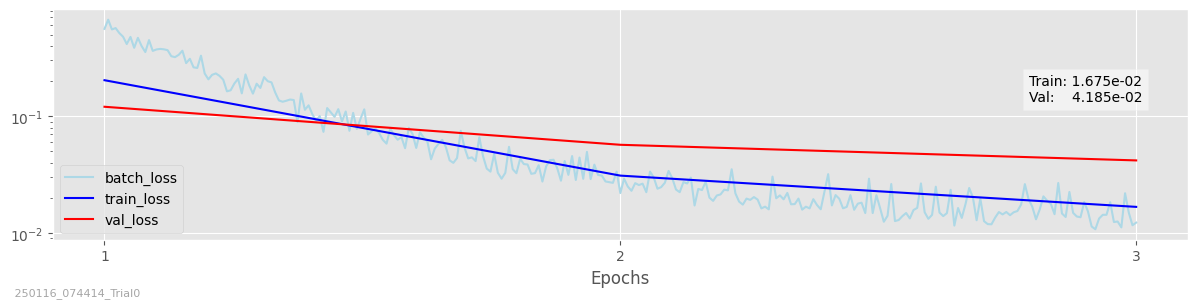

[I 2025-01-16 07:48:18,983] Trial 0 finished with value: 18.3896541595459 and parameters: {'p_factor': 0.0}. Best is trial 0 with value: 18.3896541595459.


Test Loss:		0.039278
RMSE:			18.3897        
MAE ± STD (MAPE):	16.0967 ± 9.4108 (27.35%)
R-squared:		0.2766
------------------------------------------------------------
0.1
------------------------------------------------------------
Training Started.	Process ID: 2479133 
------------------------------------------------------------
Model: LSTM1_packed_old_version	Parameters on device: CUDA:0
------------------------------------------------------------
Train/Batch size:	93 / 93
Loss:			<function objective.<locals>.loss_fn_PINN_3 at 0x7ff40e82b1a0>
Optimizer:		AdamW
LR:			0.001
Weight Decay:		0.001
------------------------------------------------------------


Epoch,Iteration,Batch Loss,Train Loss


  0%|          | 0/93 [00:00<?, ?batch/s]

  0%|          | 0/93 [00:00<?, ?batch/s]

  0%|          | 0/93 [00:00<?, ?batch/s]

------------------------------------------------------------
Training Completed.	Execution Time: 00:02:31
------------------------------------------------------------

Trial 1


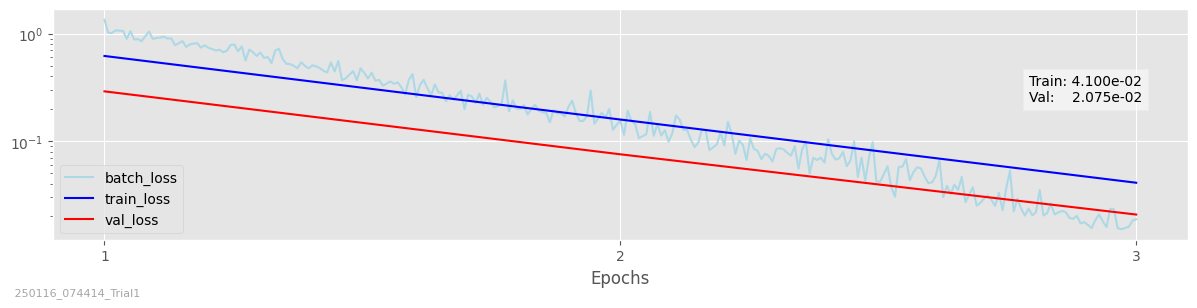

[I 2025-01-16 07:50:54,198] Trial 1 finished with value: 15.146989822387695 and parameters: {'p_factor': 0.1}. Best is trial 1 with value: 15.146989822387695.


Test Loss:		0.021884
RMSE:			15.1470        
MAE ± STD (MAPE):	12.0878 ± 12.5529 (24.09%)
R-squared:		0.5092
------------------------------------------------------------
0.2
------------------------------------------------------------
Training Started.	Process ID: 2479133 
------------------------------------------------------------
Model: LSTM1_packed_old_version	Parameters on device: CUDA:0
------------------------------------------------------------
Train/Batch size:	93 / 93
Loss:			<function objective.<locals>.loss_fn_PINN_3 at 0x7ff40c4616c0>
Optimizer:		AdamW
LR:			0.001
Weight Decay:		0.001
------------------------------------------------------------


Epoch,Iteration,Batch Loss,Train Loss


  0%|          | 0/93 [00:00<?, ?batch/s]

  0%|          | 0/93 [00:00<?, ?batch/s]

  0%|          | 0/93 [00:00<?, ?batch/s]

------------------------------------------------------------
Training Completed.	Execution Time: 00:02:31
------------------------------------------------------------

Trial 2


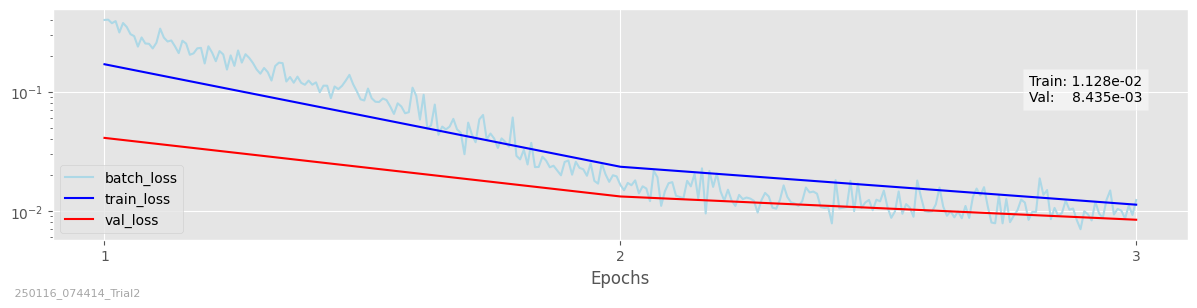

[I 2025-01-16 07:53:29,230] Trial 2 finished with value: 10.315622329711914 and parameters: {'p_factor': 0.2}. Best is trial 2 with value: 10.315622329711914.


Test Loss:		0.007694
RMSE:			10.3156        
MAE ± STD (MAPE):	8.3401 ± 9.6829 (17.39%)
R-squared:		0.7724
------------------------------------------------------------
0.3
------------------------------------------------------------
Training Started.	Process ID: 2479133 
------------------------------------------------------------
Model: LSTM1_packed_old_version	Parameters on device: CUDA:0
------------------------------------------------------------
Train/Batch size:	93 / 93
Loss:			<function objective.<locals>.loss_fn_PINN_3 at 0x7ff40c3600e0>
Optimizer:		AdamW
LR:			0.001
Weight Decay:		0.001
------------------------------------------------------------


Epoch,Iteration,Batch Loss,Train Loss


  0%|          | 0/93 [00:00<?, ?batch/s]

  0%|          | 0/93 [00:00<?, ?batch/s]

  0%|          | 0/93 [00:00<?, ?batch/s]

------------------------------------------------------------
Training Completed.	Execution Time: 00:02:31
------------------------------------------------------------

Trial 3


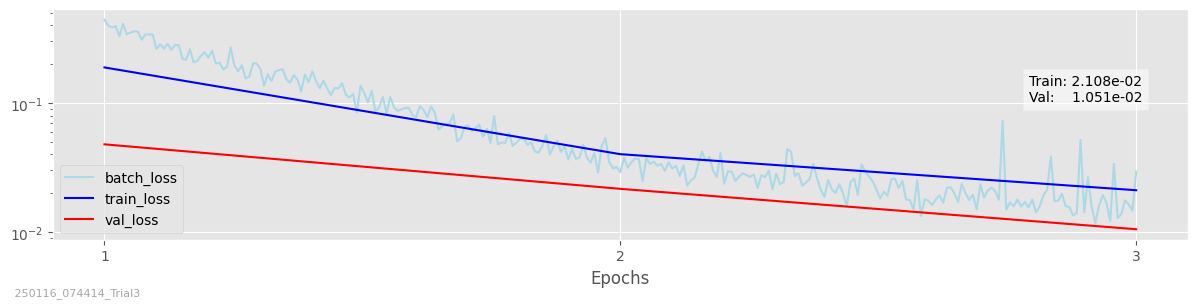

[I 2025-01-16 07:56:04,725] Trial 3 finished with value: 13.48316764831543 and parameters: {'p_factor': 0.3}. Best is trial 2 with value: 10.315622329711914.


Test Loss:		0.010293
RMSE:			13.4832        
MAE ± STD (MAPE):	11.0388 ± 12.1976 (22.70%)
R-squared:		0.6111
------------------------------------------------------------
0.4
------------------------------------------------------------
Training Started.	Process ID: 2479133 
------------------------------------------------------------
Model: LSTM1_packed_old_version	Parameters on device: CUDA:0
------------------------------------------------------------
Train/Batch size:	93 / 93
Loss:			<function objective.<locals>.loss_fn_PINN_3 at 0x7ff40c4b42c0>
Optimizer:		AdamW
LR:			0.001
Weight Decay:		0.001
------------------------------------------------------------


Epoch,Iteration,Batch Loss,Train Loss


  0%|          | 0/93 [00:00<?, ?batch/s]

  0%|          | 0/93 [00:00<?, ?batch/s]

  0%|          | 0/93 [00:00<?, ?batch/s]

------------------------------------------------------------
Training Completed.	Execution Time: 00:02:31
------------------------------------------------------------

Trial 4


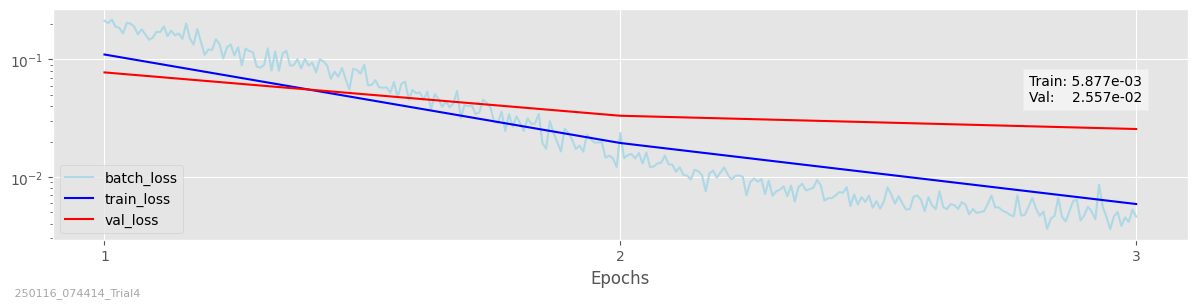

[I 2025-01-16 07:58:39,748] Trial 4 finished with value: 24.784774780273438 and parameters: {'p_factor': 0.4}. Best is trial 2 with value: 10.315622329711914.


Test Loss:		0.025863
RMSE:			24.7848        
MAE ± STD (MAPE):	22.7046 ± 11.0430 (39.97%)
R-squared:		-0.3141
------------------------------------------------------------
0.5
------------------------------------------------------------
Training Started.	Process ID: 2479133 
------------------------------------------------------------
Model: LSTM1_packed_old_version	Parameters on device: CUDA:0
------------------------------------------------------------
Train/Batch size:	93 / 93
Loss:			<function objective.<locals>.loss_fn_PINN_3 at 0x7ff40e978ae0>
Optimizer:		AdamW
LR:			0.001
Weight Decay:		0.001
------------------------------------------------------------


Epoch,Iteration,Batch Loss,Train Loss


  0%|          | 0/93 [00:00<?, ?batch/s]

  0%|          | 0/93 [00:00<?, ?batch/s]

  0%|          | 0/93 [00:00<?, ?batch/s]

------------------------------------------------------------
Training Completed.	Execution Time: 00:02:30
------------------------------------------------------------

Trial 5


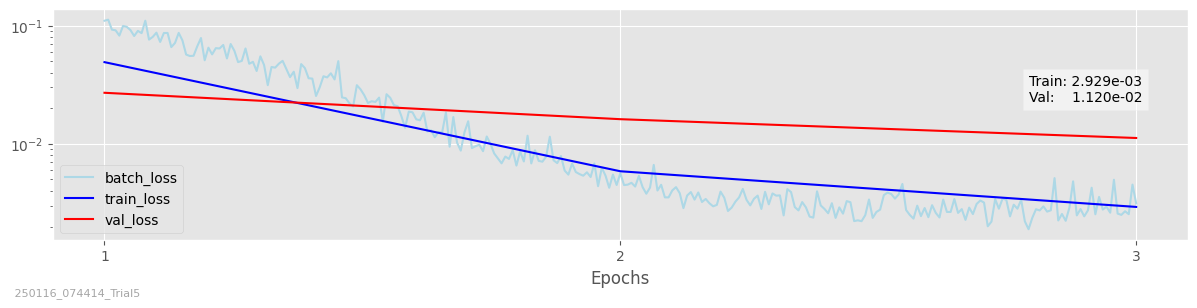

[I 2025-01-16 08:01:13,629] Trial 5 finished with value: 19.683956146240234 and parameters: {'p_factor': 0.5}. Best is trial 2 with value: 10.315622329711914.


Test Loss:		0.011014
RMSE:			19.6840        
MAE ± STD (MAPE):	17.6815 ± 11.2475 (31.03%)
R-squared:		0.1712
------------------------------------------------------------
0.6
------------------------------------------------------------
Training Started.	Process ID: 2479133 
------------------------------------------------------------
Model: LSTM1_packed_old_version	Parameters on device: CUDA:0
------------------------------------------------------------
Train/Batch size:	93 / 93
Loss:			<function objective.<locals>.loss_fn_PINN_3 at 0x7ff415f02f20>
Optimizer:		AdamW
LR:			0.001
Weight Decay:		0.001
------------------------------------------------------------


Epoch,Iteration,Batch Loss,Train Loss


  0%|          | 0/93 [00:00<?, ?batch/s]

  0%|          | 0/93 [00:00<?, ?batch/s]

  0%|          | 0/93 [00:00<?, ?batch/s]

------------------------------------------------------------
Training Completed.	Execution Time: 00:02:31
------------------------------------------------------------

Trial 6


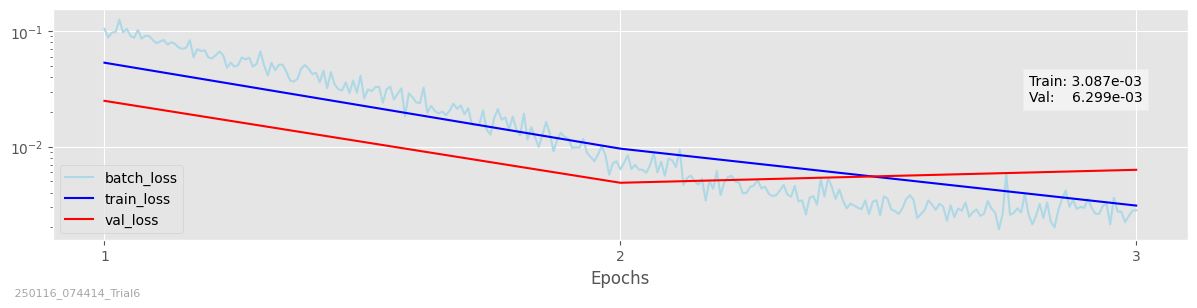

[I 2025-01-16 08:03:48,146] Trial 6 finished with value: 18.456073760986328 and parameters: {'p_factor': 0.6}. Best is trial 2 with value: 10.315622329711914.


Test Loss:		0.006533
RMSE:			18.4561        
MAE ± STD (MAPE):	16.3664 ± 10.5843 (29.81%)
R-squared:		0.2713
------------------------------------------------------------
0.7
------------------------------------------------------------
Training Started.	Process ID: 2479133 
------------------------------------------------------------
Model: LSTM1_packed_old_version	Parameters on device: CUDA:0
------------------------------------------------------------
Train/Batch size:	93 / 93
Loss:			<function objective.<locals>.loss_fn_PINN_3 at 0x7ff40e8937e0>
Optimizer:		AdamW
LR:			0.001
Weight Decay:		0.001
------------------------------------------------------------


Epoch,Iteration,Batch Loss,Train Loss


  0%|          | 0/93 [00:00<?, ?batch/s]

  0%|          | 0/93 [00:00<?, ?batch/s]

  0%|          | 0/93 [00:00<?, ?batch/s]

------------------------------------------------------------
Training Completed.	Execution Time: 00:02:31
------------------------------------------------------------

Trial 7


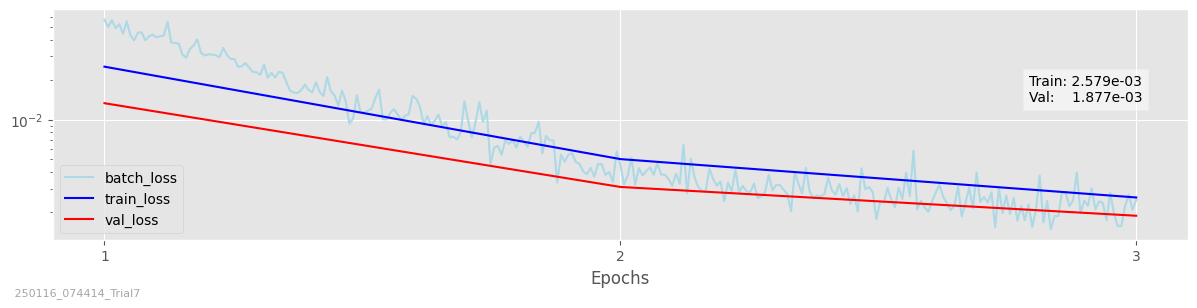

[I 2025-01-16 08:06:23,409] Trial 7 finished with value: 10.200226783752441 and parameters: {'p_factor': 0.7}. Best is trial 7 with value: 10.200226783752441.


Test Loss:		0.001770
RMSE:			10.2002        
MAE ± STD (MAPE):	8.2495 ± 10.0060 (18.97%)
R-squared:		0.7774
------------------------------------------------------------
0.8
------------------------------------------------------------
Training Started.	Process ID: 2479133 
------------------------------------------------------------
Model: LSTM1_packed_old_version	Parameters on device: CUDA:0
------------------------------------------------------------
Train/Batch size:	93 / 93
Loss:			<function objective.<locals>.loss_fn_PINN_3 at 0x7ff40e908ae0>
Optimizer:		AdamW
LR:			0.001
Weight Decay:		0.001
------------------------------------------------------------


Epoch,Iteration,Batch Loss,Train Loss


  0%|          | 0/93 [00:00<?, ?batch/s]

  0%|          | 0/93 [00:00<?, ?batch/s]

  0%|          | 0/93 [00:00<?, ?batch/s]

------------------------------------------------------------
Training Completed.	Execution Time: 00:02:32
------------------------------------------------------------

Trial 8


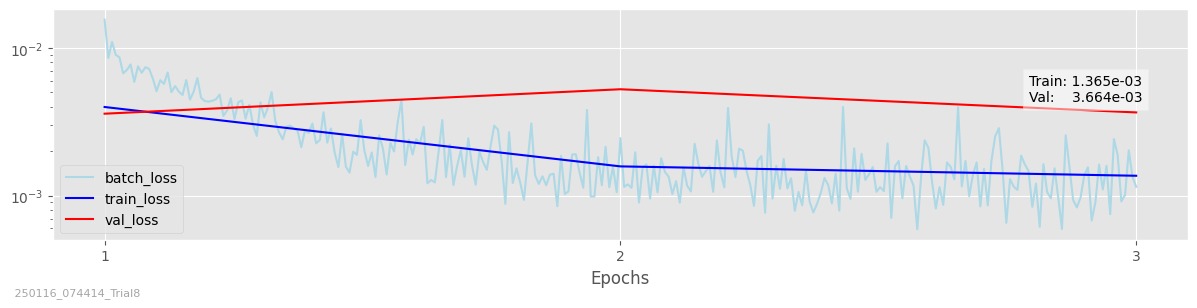

[I 2025-01-16 08:08:59,169] Trial 8 finished with value: 26.787458419799805 and parameters: {'p_factor': 0.8}. Best is trial 7 with value: 10.200226783752441.


Test Loss:		0.003567
RMSE:			26.7875        
MAE ± STD (MAPE):	25.1159 ± 9.5209 (45.98%)
R-squared:		-0.5350
------------------------------------------------------------
0.9
------------------------------------------------------------
Training Started.	Process ID: 2479133 
------------------------------------------------------------
Model: LSTM1_packed_old_version	Parameters on device: CUDA:0
------------------------------------------------------------
Train/Batch size:	93 / 93
Loss:			<function objective.<locals>.loss_fn_PINN_3 at 0x7ff40e97a8e0>
Optimizer:		AdamW
LR:			0.001
Weight Decay:		0.001
------------------------------------------------------------


Epoch,Iteration,Batch Loss,Train Loss


  0%|          | 0/93 [00:00<?, ?batch/s]

  0%|          | 0/93 [00:00<?, ?batch/s]

  0%|          | 0/93 [00:00<?, ?batch/s]

------------------------------------------------------------
Training Completed.	Execution Time: 00:02:30
------------------------------------------------------------

Trial 9


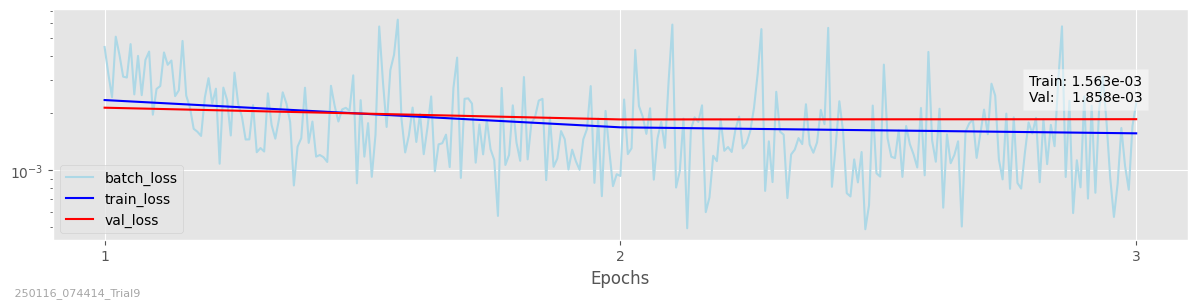

[I 2025-01-16 08:11:33,575] Trial 9 finished with value: 25.06883430480957 and parameters: {'p_factor': 0.9}. Best is trial 7 with value: 10.200226783752441.


Test Loss:		0.001514
RMSE:			25.0688        
MAE ± STD (MAPE):	21.1033 ± 14.5203 (39.88%)
R-squared:		-0.3443
------------------------------------------------------------
1.0
------------------------------------------------------------
Training Started.	Process ID: 2479133 
------------------------------------------------------------
Model: LSTM1_packed_old_version	Parameters on device: CUDA:0
------------------------------------------------------------
Train/Batch size:	93 / 93
Loss:			<function objective.<locals>.loss_fn_PINN_3 at 0x7ff3bf8d8ae0>
Optimizer:		AdamW
LR:			0.001
Weight Decay:		0.001
------------------------------------------------------------


Epoch,Iteration,Batch Loss,Train Loss


  0%|          | 0/93 [00:00<?, ?batch/s]

  0%|          | 0/93 [00:00<?, ?batch/s]

  0%|          | 0/93 [00:00<?, ?batch/s]

------------------------------------------------------------
Training Completed.	Execution Time: 00:01:55
------------------------------------------------------------

Trial 10


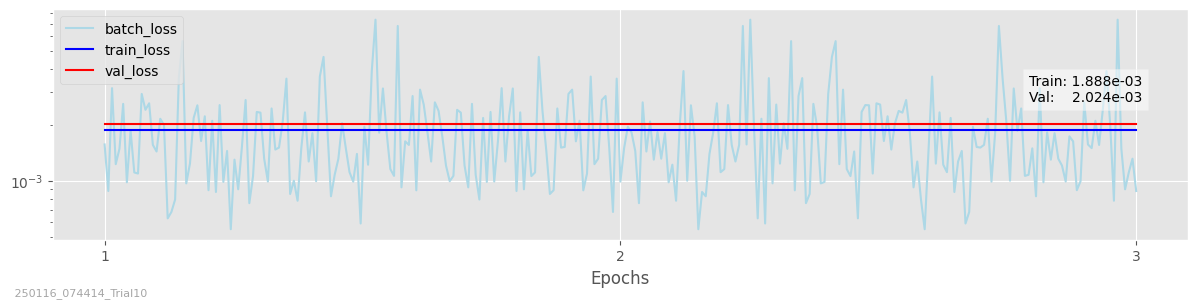

[I 2025-01-16 08:13:31,440] Trial 10 finished with value: 65.49818420410156 and parameters: {'p_factor': 1.0}. Best is trial 7 with value: 10.200226783752441.


Test Loss:		0.001600
RMSE:			65.4982        
MAE ± STD (MAPE):	59.5260 ± 27.3254 (102.52%)
R-squared:		-8.1770
------------------------------------------------------------
Trial 0: p_factor = 0.0, Value = 18.3896541595459
Trial 1: p_factor = 0.1, Value = 15.146989822387695
Trial 2: p_factor = 0.2, Value = 10.315622329711914
Trial 3: p_factor = 0.3, Value = 13.48316764831543
Trial 4: p_factor = 0.4, Value = 24.784774780273438
Trial 5: p_factor = 0.5, Value = 19.683956146240234
Trial 6: p_factor = 0.6, Value = 18.456073760986328
Trial 7: p_factor = 0.7, Value = 10.200226783752441
Trial 8: p_factor = 0.8, Value = 26.787458419799805
Trial 9: p_factor = 0.9, Value = 25.06883430480957
Trial 10: p_factor = 1.0, Value = 65.49818420410156


In [8]:
# OPTUNA: STUDY -------------------------------------------------------------------
study = optuna.create_study(direction='minimize', sampler = optuna.samplers.TPESampler())    # TPESampler, RandomSampler, GridSampler, CmaEsSampler, NSGAIISampler

# Enqueue trials with the specified learning rates in ascending order
p_factors = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for l_p in p_factors: study.enqueue_trial({'p_factor': l_p})


study.optimize(objective, n_trials=len(p_factors))

# Print the results
for trial in study.trials:
    print(f"Trial {trial.number}: p_factor = {trial.params['p_factor']}, Value = {trial.value}")

___
SAVE CHECKPOINT

In [9]:
# Save the best trial config to a text file
best_trial = study.best_trial
best_trial_dict = {'params': best_trial.params, 'value': best_trial.value}
with open(Path(LOG_FILE_NAME).with_name(f"{TS}_BEST_IS_{best_trial.number}.txt"), 'w') as f: json.dump(best_trial_dict, f, indent=4)
print("Best Trial: ", best_trial.number); print("Best hyperparameters: ", study.best_params)
trials_df = study.trials_dataframe()
print(tabulate(trials_df, headers='keys', tablefmt='psql'))
trials_df.to_csv('trials_overview.csv', index=False)

Best Trial:  7
Best hyperparameters:  {'p_factor': 0.7}
+----+----------+---------+----------------------------+----------------------------+------------------------+-------------------+-----------------------------+----------+
|    |   number |   value | datetime_start             | datetime_complete          | duration               |   params_p_factor | system_attrs_fixed_params   | state    |
|----+----------+---------+----------------------------+----------------------------+------------------------+-------------------+-----------------------------+----------|
|  0 |        0 | 18.3897 | 2025-01-16 07:45:39.971492 | 2025-01-16 07:48:18.983401 | 0 days 00:02:39.011909 |               0   | {'p_factor': 0.0}           | COMPLETE |
|  1 |        1 | 15.147  | 2025-01-16 07:48:18.985450 | 2025-01-16 07:50:54.197848 | 0 days 00:02:35.212398 |               0.1 | {'p_factor': 0.1}           | COMPLETE |
|  2 |        2 | 10.3156 | 2025-01-16 07:50:54.203798 | 2025-01-16 07:53:29.230455 